In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Carga de imagenes

Realizmaos una ordenacion de las imagenes para poder realizar las predicciones de forma mas correcta

blabla

In [2]:
# Función para obtener rutas ordenadas por nombre de archivo
def get_sorted_paths(folder, extension="tiff"):
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(extension)]
    )

# Rutas de las imágenes y las máscaras
img_paths = get_sorted_paths("roads/sat", extension="tiff")
mask_paths = get_sorted_paths("roads/gt", extension="tif")

# Verifica que el orden coincida
for img, mask in zip(img_paths, mask_paths):
    print(f"Imagen: {os.path.basename(img)}, Máscara: {os.path.basename(mask)}")

# Verificar si se encontraron archivos
if len(img_paths) == 0 or len(mask_paths) == 0:
    print("No se encontraron imágenes o máscaras. Verifica las rutas.")
else:
    print(f"Imágenes encontradas: {len(img_paths)} | Máscaras encontradas: {len(mask_paths)}")


Imagen: 10078675_15.tiff, Máscara: 10078675_15.tif
Imagen: 10228675_15.tiff, Máscara: 10228675_15.tif
Imagen: 10228705_15.tiff, Máscara: 10228705_15.tif
Imagen: 10228720_15.tiff, Máscara: 10228720_15.tif
Imagen: 10228735_15.tiff, Máscara: 10228735_15.tif
Imagen: 10228750_15.tiff, Máscara: 10228750_15.tif
Imagen: 10378675_15.tiff, Máscara: 10378675_15.tif
Imagen: 10378690_15.tiff, Máscara: 10378690_15.tif
Imagen: 10378705_15.tiff, Máscara: 10378705_15.tif
Imagen: 10378720_15.tiff, Máscara: 10378720_15.tif
Imagen: 10378735_15.tiff, Máscara: 10378735_15.tif
Imagen: 10378750_15.tiff, Máscara: 10378750_15.tif
Imagen: 10378765_15.tiff, Máscara: 10378765_15.tif
Imagen: 10528675_15.tiff, Máscara: 10528675_15.tif
Imagen: 10528690_15.tiff, Máscara: 10528690_15.tif
Imagen: 10528705_15.tiff, Máscara: 10528705_15.tif
Imagen: 10528720_15.tiff, Máscara: 10528720_15.tif
Imagen: 10528735_15.tiff, Máscara: 10528735_15.tif
Imagen: 10528750_15.tiff, Máscara: 10528750_15.tif
Imagen: 10528765_15.tiff, Másca

#### No se utiliza el preprocesado ya que da peor, pero lo dejo para explicar que da peor

In [3]:
def standardize_image(img):
    normalized_img = np.zeros_like(img)
    # Estandarizar cada canal de color independientemente
    for channel in range(img.shape[-1]):
        img_channel = img[..., channel]
        mean = np.mean(img_channel)
        std = np.std(img_channel)
        # Estandarizar
        normalized_channel = (img_channel - mean) / (std + 1e-7)
        # Escalar a [0,1] de forma más controlada
        normalized_channel = (normalized_channel - normalized_channel.min()) / (normalized_channel.max() - normalized_channel.min())
        normalized_img[..., channel] = normalized_channel
    return normalized_img

def enhance_contrast(img):
    # Convertir a LAB y mejorar el canal L
    lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    # Reducir clipLimit para un contraste más suave
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    enhanced = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
    return enhanced.astype('float32') / 255.0

def reduce_noise(img):
    # Aplicar filtro bilateral con parámetros más suaves
    denoised = cv2.bilateralFilter((img * 255).astype(np.uint8), 
                                 d=7,        # Reducido de 9 a 7
                                 sigmaColor=50,  # Reducido de 75 a 50
                                 sigmaSpace=50)  # Reducido de 75 a 50
    return denoised.astype('float32') / 255.0

## La carga como tal de datos

In [4]:
def load_data(img_paths, mask_paths, img_size=(512, 512), preprocess=True):
    imgs = []
    masks = []
    
    for img_path, mask_path in zip(img_paths, mask_paths):
            # Verify files exist
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image not found: {img_path}")
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found: {mask_path}")
                
            # Load and resize image
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Failed to load image: {img_path}")
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            
            if preprocess:
                img = reduce_noise(img)
                img = enhance_contrast(img)
                img = standardize_image(img)
                
            imgs.append(img)
            
            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Failed to load mask: {mask_path}")
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype('float32') # Binarize the mask
            masks.append(mask)
            
    return np.array(imgs), np.array(masks)

# Cargar los datos con preprocesamiento
IMAGES, MASKS = load_data(img_paths, mask_paths, preprocess=False)
print("Number of images: " , len(IMAGES), "Number of masks: ", len(MASKS))

Number of images:  20 Number of masks:  20


In [5]:
def visualize_preprocessing(images_original, images_processed, masks, num_samples=2):
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    
    for idx in range(num_samples):
        # Mostrar imagen original
        axs[0, idx].imshow(images_original[idx])
        axs[0, idx].set_title(f'Original {idx+1}')
        axs[0, idx].axis('off')
        
        # Mostrar imagen procesada
        axs[1, idx].imshow(images_processed[idx])
        axs[1, idx].set_title(f'Procesada {idx+1}')
        axs[1, idx].axis('off')
        
        # Mostrar máscara
        axs[2, idx].imshow(masks[idx], cmap='gray')
        axs[2, idx].set_title(f'Máscara {idx+1}')
        axs[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Cargar imágenes originales sin preprocesamiento
IMAGES_ORIGINAL, _ = load_data(img_paths, mask_paths, preprocess=False)

# Visualizar la comparación
# visualize_preprocessing(IMAGES_ORIGINAL, IMAGES, MASKS)

# Division en conjunto de entrenamiento y de test

In [6]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y validación (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    IMAGES, 
    MASKS, 
    test_size=0.2, 
    random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)

def verify_data():
    # Verificar rango de valores
    print("Rango de valores X_train:", X_train.min(), "-", X_train.max())
    print("Valores únicos en y_train:", np.unique(y_train))
    
    # Calcular proporción de píxeles de carretera vs no carretera
    road_ratio = np.mean(y_train) * 100
    print(f"\nPorcentaje de píxeles de carretera: {road_ratio:.2f}%")

verify_data()

Tamaño del conjunto de entrenamiento: (16, 512, 512, 3)
Tamaño del conjunto de validación: (4, 512, 512, 3)
Rango de valores X_train: 0.007843138 - 1.0
Valores únicos en y_train: [0. 1.]

Porcentaje de píxeles de carretera: 4.19%


# BASELINE
## NO DOWNSAMPLING 
## NO EXTRACT FEATURES

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
import numpy as np

# Preparar los datos en formato 2D (píxeles x características)
X_train_baseline = X_train.reshape(-1, 3)  # Cada píxel con sus 3 canales RGB
y_train_baseline = y_train.reshape(-1)     # Aplanar las máscaras

X_val_baseline = X_val.reshape(-1, 3)
y_val_baseline = y_val.reshape(-1)

print("Forma de X_train_baseline:", X_train_baseline.shape)
print("Forma de y_train_baseline:", y_train_baseline.shape)

# Entrenar un Random Forest básico
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Entrenar el modelo
rf_baseline.fit(X_train_baseline, y_train_baseline)

# Predicciones
y_pred_baseline = rf_baseline.predict(X_val_baseline)

# Calcular métricas
def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Dice': 2 * np.sum(y_pred * y_true) / (np.sum(y_pred) + np.sum(y_true)),
        'AUC': roc_auc_score(y_true, y_pred)
    }
    return metrics

baseline_metrics = calculate_metrics(y_val_baseline, y_pred_baseline)
for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")

Forma de X_train_baseline: (4194304, 3)
Forma de y_train_baseline: (4194304,)
Accuracy: 0.9462
F1-Score: 0.2180
Precision: 0.4161
Recall: 0.1476
Dice: 0.2180
AUC: 0.5683


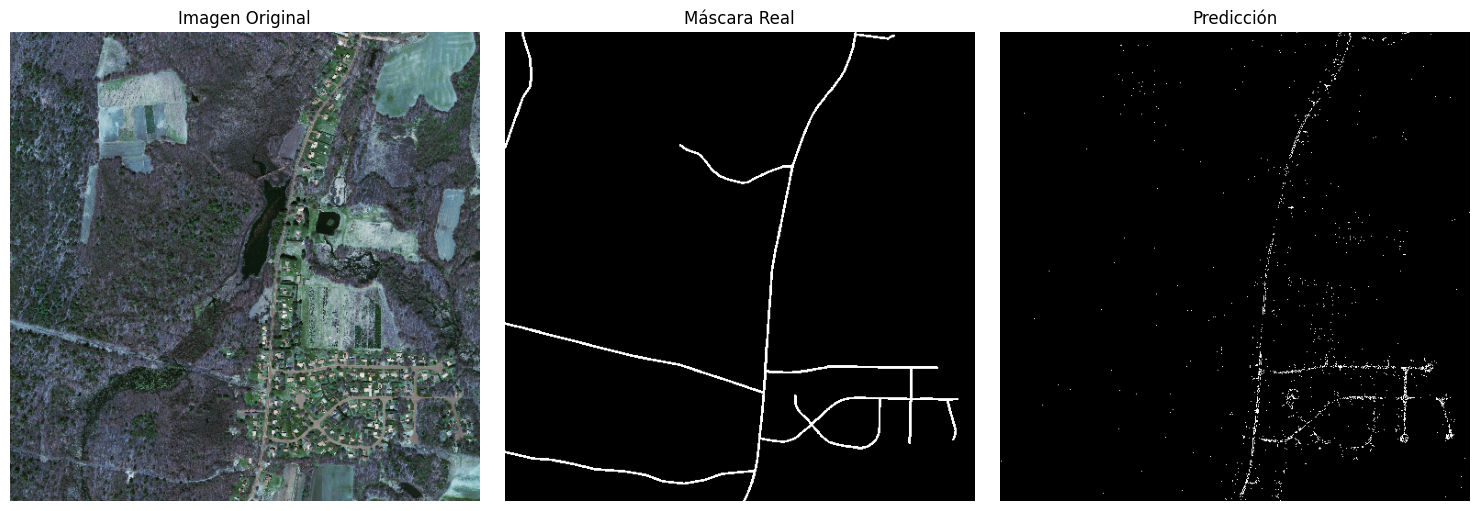

In [8]:
# Reformar las predicciones a la forma de imagen
predictions_reshaped = y_pred_baseline.reshape(X_val.shape[0], 512, 512)

def visualize_predictions(X_val, y_val, predictions, idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Imagen original
    axs[0].imshow(X_val[idx])
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')
    
    # Máscara real
    axs[1].imshow(y_val[idx], cmap='gray')  # Eliminado el [:,:,0]
    axs[1].set_title('Máscara Real')
    axs[1].axis('off')
    
    # Predicción
    axs[2].imshow(predictions[idx], cmap='gray')
    axs[2].set_title('Predicción')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar para la primera imagen de validación
visualize_predictions(X_val, y_val, predictions_reshaped)

# Balanceo de clases

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

def balance_and_train(X_train, y_train, n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2):
    """
    Balancea los datos, entrena un Random Forest y devuelve el modelo entrenado y las métricas.
    
    Parameters:
    - X_train: Características de entrenamiento.
    - y_train: Etiquetas de entrenamiento.
    - n_estimators, max_depth, min_samples_leaf, min_samples_split: Hiperparámetros del Random Forest.
    
    Returns:
    - rf_model: Modelo entrenado.
    """
    # Asegurarse de que las etiquetas están aplanadas
    # y_train_flat = y_train.flatten()
    
    # Balancear clases
    X_train_road = X_train[y_train == 1]
    y_train_road = y_train[y_train == 1]

    X_train_noroad = X_train[y_train == 0]
    y_train_noroad = y_train[y_train == 0]

    X_train_noroad_downsampled = resample(X_train_noroad,
                                        n_samples=len(X_train_road) * 2,
                                        random_state=42)
    y_train_noroad_downsampled = np.zeros(len(X_train_noroad_downsampled))

    # Combinar datos balanceados
    X_train_balanced = np.vstack([X_train_road, X_train_noroad_downsampled])
    y_train_balanced = np.hstack([y_train_road, y_train_noroad_downsampled])

    # Entrenar modelo Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_jobs=-1,
        random_state=42
    )
    rf_model.fit(X_train_balanced, y_train_balanced)

    return rf_model


In [10]:
from sklearn.utils import resample

# Separar las clases
X_train_road = X_train_baseline[y_train_baseline == 1]
y_train_road = y_train_baseline[y_train_baseline == 1]

X_train_noroad = X_train_baseline[y_train_baseline == 0]
y_train_noroad = y_train_baseline[y_train_baseline == 0]

print("Antes del balanceo:")
print("Muestras de carretera:", len(X_train_road))
print("Muestras de no-carretera:", len(X_train_noroad))

# Downsample la clase mayoritaria (no-carretera)
# Podemos ajustar el ratio, por ejemplo a 1:1 o 1:2
X_train_noroad_downsampled = resample(X_train_noroad,
                                    n_samples=len(X_train_road) * 2,  # ratio 1:2
                                    random_state=42)
y_train_noroad_downsampled = np.zeros(len(X_train_noroad_downsampled))

# Combinar los datos balanceados
X_train_balanced = np.vstack([X_train_road, X_train_noroad_downsampled])
y_train_balanced = np.hstack([y_train_road, y_train_noroad_downsampled])

print("\nDespués del balanceo:")
print("Muestras totales:", len(X_train_balanced))
print("Ratio carretera/no-carretera:", len(X_train_road) / len(X_train_noroad_downsampled),"%")

Antes del balanceo:
Muestras de carretera: 175556
Muestras de no-carretera: 4018748

Después del balanceo:
Muestras totales: 526668
Ratio carretera/no-carretera: 0.5 %


# COLOR

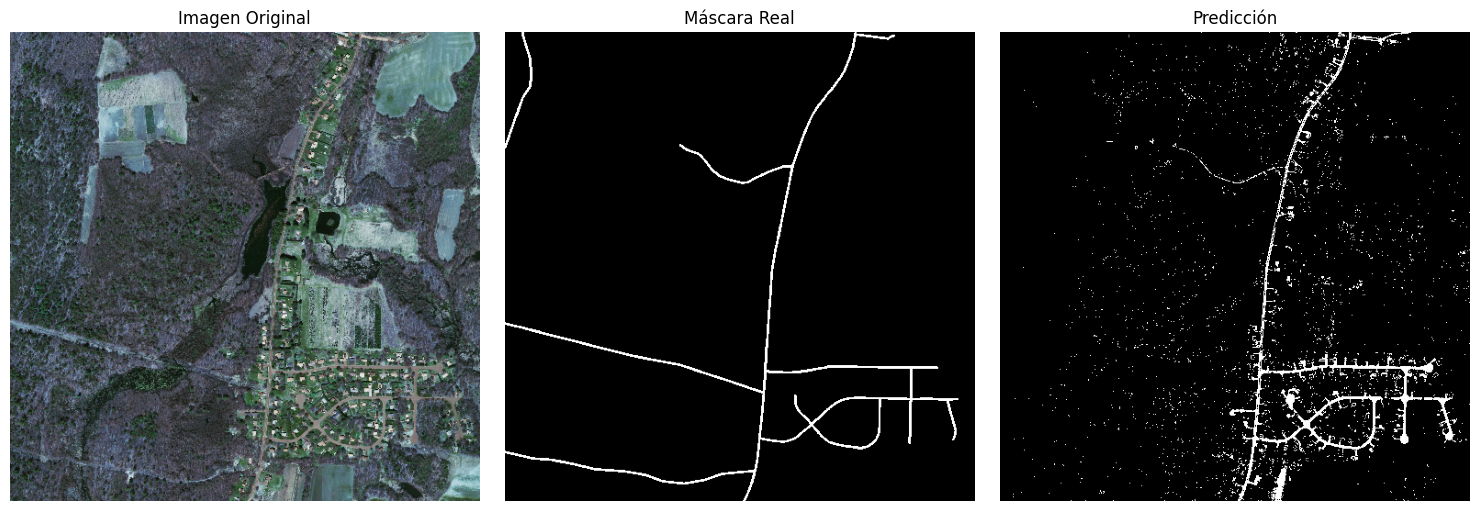

Métricas para características de color:
Accuracy: 0.8954
F1-Score: 0.4228
Precision: 0.2937
Recall: 0.7547
Dice: 0.4228
AUC: 0.8288


In [11]:
def color_extractor(image):
    """
    Extrae características de color de manera optimizada
    """
    # Convertir a HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calcular estadísticas globales
    mean_hsv = np.mean(hsv, axis=(0,1))
    std_hsv = np.std(hsv, axis=(0,1))
    
    # Reshape para tener una característica por píxel
    pixel_features = hsv.reshape(-1, 3)
    
    # Agregar características globales a cada píxel
    global_features = np.tile(np.concatenate([mean_hsv, std_hsv]), (pixel_features.shape[0], 1))
    
    # Combinar características
    features = np.hstack([pixel_features, global_features])
    
    return features

def process_images_color(images):
    """
    Procesa un conjunto de imágenes para extraer características de color.
    """
    features_list = []
    for img in images:
        features = color_extractor(img)
        features_list.append(features)
    return np.vstack(features_list)

# Ahora usa esta función en lugar de pasar X_train/X_val directamente:
X_train_color = process_images_color(X_train)
X_val_color = process_images_color(X_val)


# Extraer características de color
X_train_color = process_images_color(X_train)
X_val_color = process_images_color(X_val)

# Entrenar modelo con características de color
rf_color = balance_and_train(X_train_color, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_color = rf_color.predict(X_val_color)

# Calcular métricas
color_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_color)

# Visualizar predicciones
predictions_reshaped = y_pred_color.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características de color:")
for metric, value in color_metrics.items():
    print(f"{metric}: {value:.4f}")

# Textura

/home/clown/classroom/PVC_investigacion/Computer-Vision/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


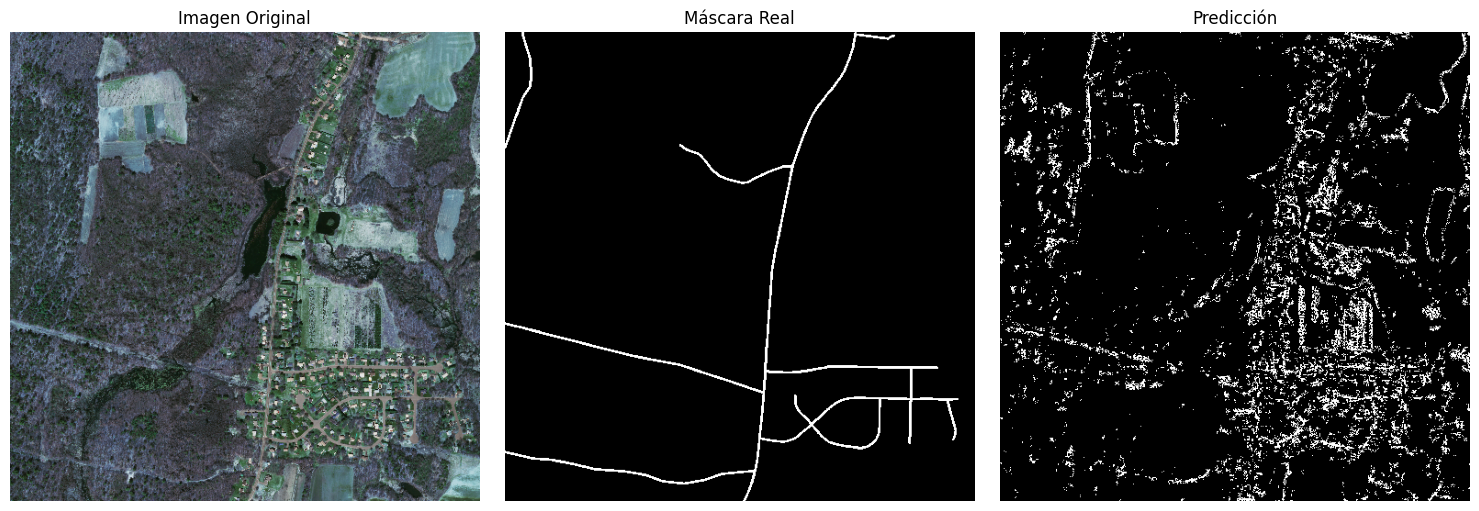

Métricas para características de textura:
Accuracy: 0.8472
F1-Score: 0.1772
Precision: 0.1219
Recall: 0.3242
Dice: 0.1772
AUC: 0.5997


In [12]:
from skimage.feature import local_binary_pattern
from scipy.ndimage import generic_filter

def extract_texture_features(images, lbp_radius=2, lbp_points=16):
    """
    Extraer características de textura mejoradas usando:
    - LBP (Local Binary Pattern) con ajustes de parámetros.
    - Desviación estándar local optimizada usando convolución.
    """
    features_list = []
   
    for img in images:
        # Convertir a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
       
        # Calcular LBP con parámetros mejorados
        lbp = local_binary_pattern(gray, lbp_points, lbp_radius, method='uniform').flatten()
       
        # Calcular desviación estándar local usando convolución
        def local_std_func(block):
            return np.std(block)
        
        local_std = generic_filter(
            gray.astype(float),
            local_std_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()

        # Agregar el rango de valores locales como característica adicional
        def local_range_func(block):
            return block.max() - block.min()
        
        local_range = generic_filter(
            gray.astype(float),
            local_range_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()
       
        # Combinar características
        texture_features = np.column_stack([lbp, local_std, local_range])
        features_list.append(texture_features)
   
    return np.vstack(features_list)

# Extraer las características de textura mejoradas
X_train_texture = extract_texture_features(X_train)
X_val_texture = extract_texture_features(X_val)

# Entrenar modelo con características de textura utilizando la función generalizada
rf_texture = balance_and_train(X_train_texture, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_texture = rf_texture.predict(X_val_texture)

# Calcular métricas
texture_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_texture)

# Visualizar predicciones
predictions_reshaped = y_pred_texture.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características de textura:")
for metric, value in texture_metrics.items():
    print(f"{metric}: {value:.4f}")


# Gabor

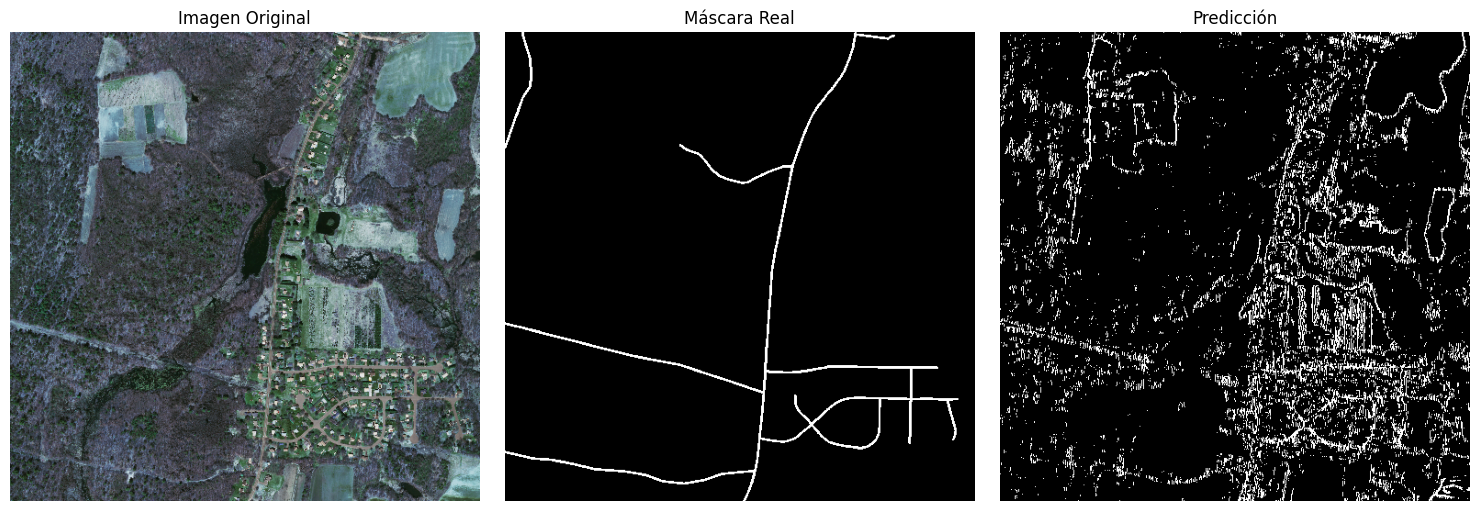

Métricas para características de Gabor:
Accuracy: 0.8246
F1-Score: 0.1913
Precision: 0.1249
Recall: 0.4089
Dice: 0.1913
AUC: 0.6279


In [13]:
from skimage.filters import gabor
from scipy.ndimage import generic_filter

def extract_gabor_features(images, frequency=0.6):
    """
    Extraer características usando filtros Gabor.
    """
    features_list = []
    
    for img in images:
        # Convertir a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Aplicar filtro Gabor (frecuencia específica)
        real, _ = gabor(gray, frequency=frequency)
        
        # Calcular desviación estándar local usando convolución
        def local_std_func(block):
            return np.std(block)
        
        local_std = generic_filter(
            gray.astype(float),
            local_std_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()

        # Agregar el rango de valores locales como característica adicional
        def local_range_func(block):
            return block.max() - block.min()
        
        local_range = generic_filter(
            gray.astype(float),
            local_range_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()
        
        # Combinar características (Gabor + Estadísticas locales)
        gabor_features = real.flatten()
        texture_features = np.column_stack([gabor_features, local_std, local_range])
        features_list.append(texture_features)
    
    return np.vstack(features_list)

# Extraer las características usando Gabor
X_train_gabor = extract_gabor_features(X_train)
X_val_gabor = extract_gabor_features(X_val)

# Entrenar modelo con características de Gabor utilizando la función generalizada
rf_gabor = balance_and_train(X_train_gabor, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_gabor = rf_gabor.predict(X_val_gabor)

# Calcular métricas
gabor_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_gabor)

# Visualizar predicciones
predictions_reshaped = y_pred_gabor.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características de Gabor:")
for metric, value in gabor_metrics.items():
    print(f"{metric}: {value:.4f}")


# Spectral

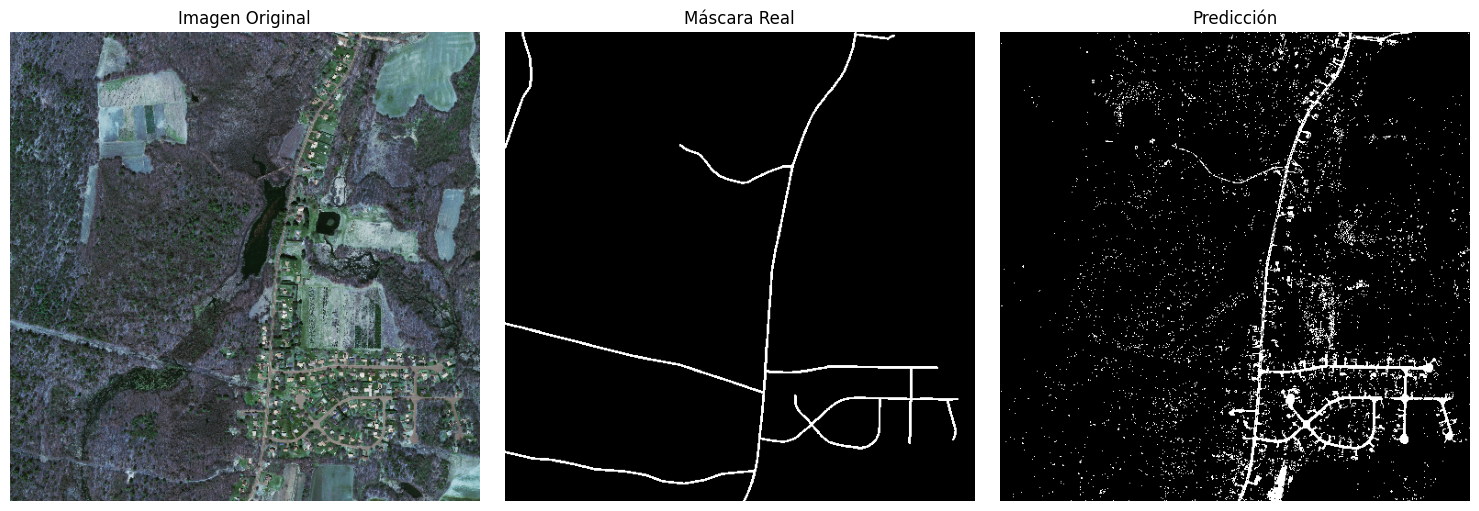

Métricas para características espectrales:
Accuracy: 0.8824
F1-Score: 0.4017
Precision: 0.2708
Recall: 0.7779
Dice: 0.4017
AUC: 0.8329


In [14]:
import numpy as np

def spectral_extractor(image):
    """
    Extrae características espectrales incluyendo NDVI y otros índices.
    """
    # Asegurar que la imagen sea float
    img_float = image.astype(float) + 1e-6
    
    # Extraer canales
    b = img_float[:, :, 0]
    g = img_float[:, :, 1]
    r = img_float[:, :, 2]
    
    # Calcular NDVI (usando R como NIR y B como Red)
    ndvi = (r - b) / (r + b)
    
    # Calcular otros índices espectrales
    # Índice de vegetación ajustado al suelo (SAVI)
    L = 0.5
    savi = ((r - b) * (1 + L)) / (r + b + L)
    
    # Índice de vegetación mejorado (EVI)
    evi = 2.5 * ((r - b) / (r + 6 * b - 7.5 * g + 1))
    
    # Combinar características
    features = np.column_stack([
        r.flatten(),
        g.flatten(),
        b.flatten(),
        ndvi.flatten(),
        savi.flatten(),
        evi.flatten()
    ])
    
    return features

def process_images_spectral(images):
    """
    Procesa un conjunto de imágenes para extraer características espectrales.
    """
    features_list = []
    for img in images:
        features = spectral_extractor(img)
        features_list.append(features)
    return np.vstack(features_list)

# Extraer características espectrales para el conjunto de entrenamiento y validación
X_train_spectral = process_images_spectral(X_train)
X_val_spectral = process_images_spectral(X_val)

# Entrenar modelo con características espectrales utilizando la función generalizada
rf_spectral = balance_and_train(X_train_spectral, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_spectral = rf_spectral.predict(X_val_spectral)

# Calcular métricas
spectral_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_spectral)

# Visualizar predicciones
predictions_reshaped = y_pred_spectral.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características espectrales:")
for metric, value in spectral_metrics.items():
    print(f"{metric}: {value:.4f}")


# Todos los filtros

/home/clown/classroom/PVC_investigacion/Computer-Vision/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


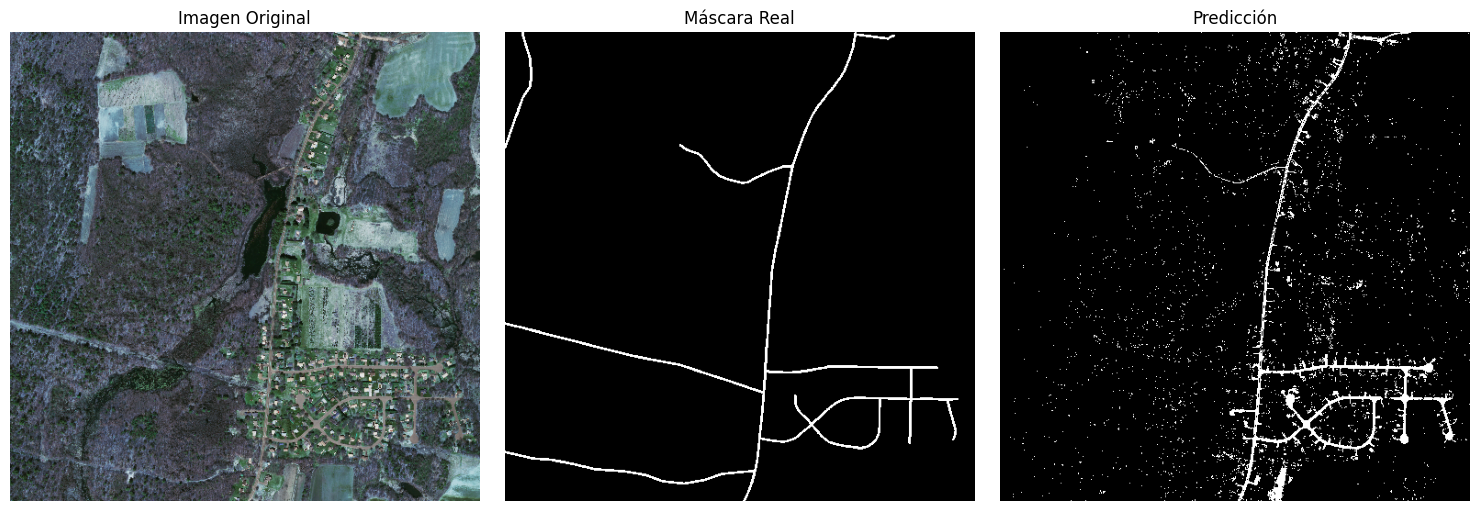

Métricas para características combinadas:
Accuracy: 0.9072
F1-Score: 0.4572
Precision: 0.3251
Recall: 0.7701
Dice: 0.4572
AUC: 0.8423


In [15]:
# Extraer características espectrales
X_train_spectral = process_images_spectral(X_train)
X_val_spectral = process_images_spectral(X_val)

# Extraer características Gabor
X_train_gabor = extract_gabor_features(X_train)
X_val_gabor = extract_gabor_features(X_val)

# Extraer características de textura
X_train_texture = extract_texture_features(X_train)
X_val_texture = extract_texture_features(X_val)

# Extraer características de color
X_train_color = process_images_color(X_train)
X_val_color = process_images_color(X_val)

# Combinar todas las características
X_train_all = np.hstack([X_train_spectral, X_train_gabor, X_train_texture, X_train_color])
X_val_all = np.hstack([X_val_spectral, X_val_gabor, X_val_texture, X_val_color])

# Entrenar el modelo con características combinadas utilizando la función generalizada
rf_all = balance_and_train(X_train_all, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_all = rf_all.predict(X_val_all)

# Calcular métricas
all_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_all)

# Dar forma a las predicciones para visualización
predictions_reshaped = y_pred_all.reshape(X_val.shape[0], 512, 512)

# Dar forma a las etiquetas de validación antes de visualizar
y_val_reshaped = y_val_baseline.reshape(X_val.shape[0], 512, 512)

# Visualizar resultados con las etiquetas re-formadas
visualize_predictions(X_val, y_val_reshaped, predictions_reshaped)

# Imprimir métricas
print("Métricas para características combinadas:")
for metric, value in all_metrics.items():
    print(f"{metric}: {value:.4f}")


# Leve Postprocesado que no funciona

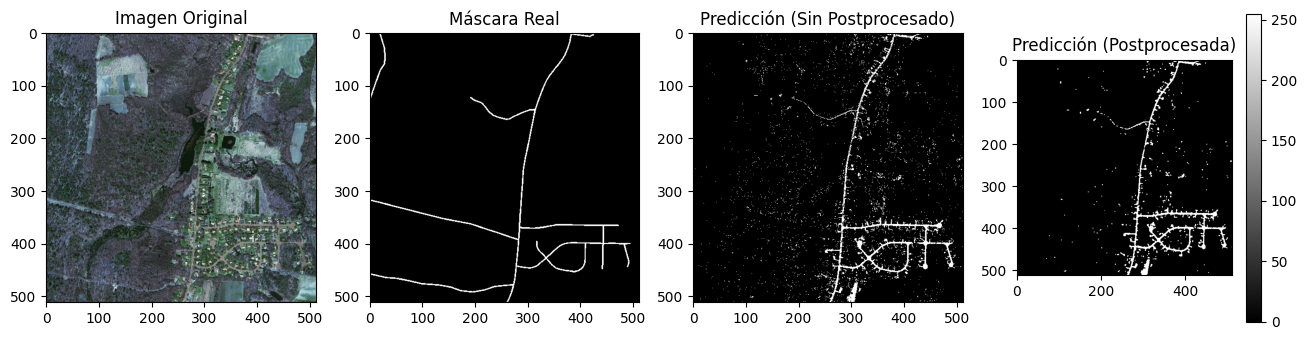

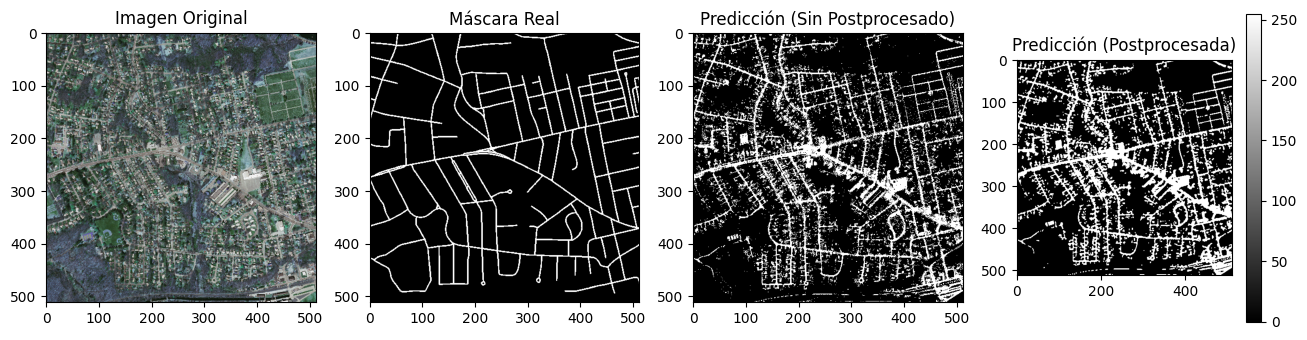

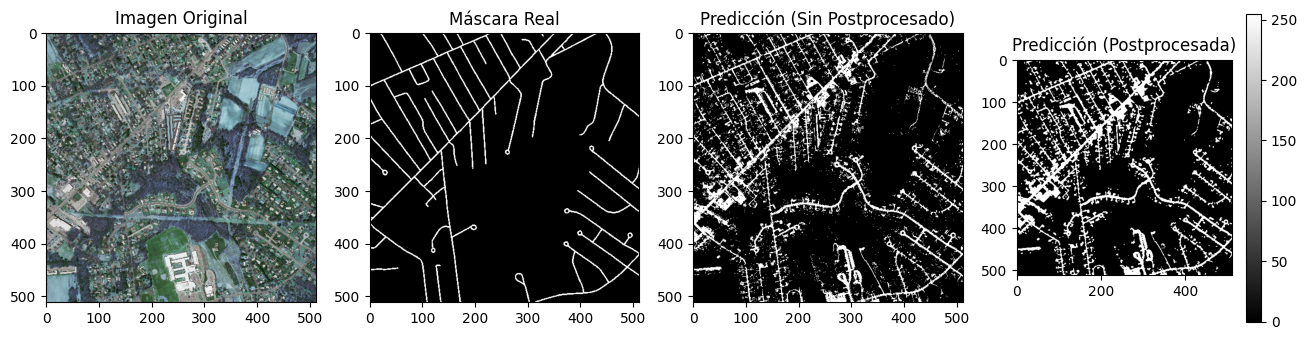

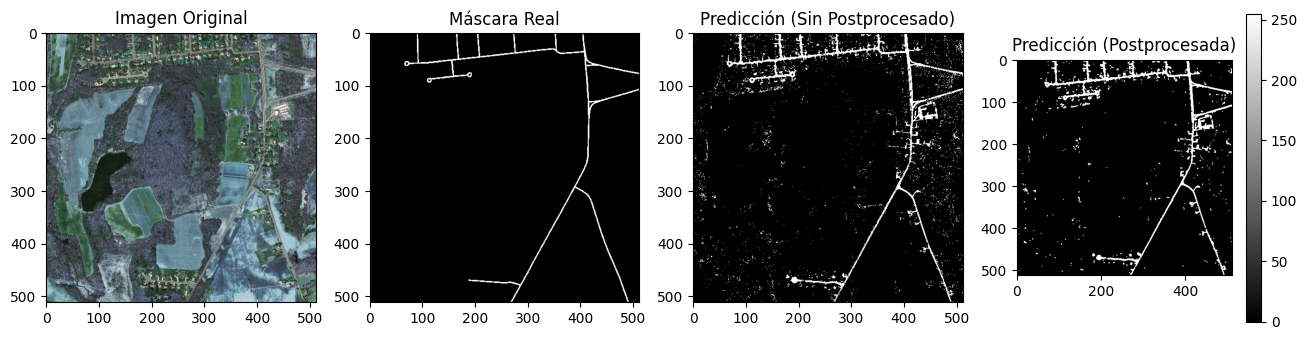

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Postprocesado de las predicciones
predictions_postprocessed = []
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))  # Dilatación
kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))   # Erosión asimétrica

for pred in predictions_reshaped:
    # Asegurar que los datos están en formato uint8
    pred = (pred * 255).astype(np.uint8)

    # Suavizar ligeramente para eliminar ruido
    pred_smooth = cv2.GaussianBlur(pred, (3, 3), 0)

    # Binarizar la imagen
    _, pred_binary = cv2.threshold(pred_smooth, 100, 255, cv2.THRESH_BINARY)

    # Paso 1: Dilatación para conectar líneas
    pred_post = cv2.dilate(pred_binary, kernel_dilate, iterations=1)

    # Paso 2: Erosión para adelgazar las líneas
    pred_post = cv2.erode(pred_post, kernel_erode, iterations=1)

    # Paso 3: Apertura final para eliminar ruido pequeño
    pred_post = cv2.morphologyEx(pred_post, cv2.MORPH_OPEN, kernel_erode)

    predictions_postprocessed.append(pred_post)

predictions_postprocessed = np.array(predictions_postprocessed)

# Obtener el número máximo de imágenes disponibles
num_images = min(20, len(X_val), len(predictions_postprocessed))

# Visualización de resultados
for i in range(num_images):  # Mostrar hasta 20 imágenes o el máximo disponible
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title("Imagen Original")
    plt.imshow(X_val[i])

    plt.subplot(1, 4, 2)
    plt.title("Máscara Real")
    plt.imshow(y_val_reshaped[i], cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("Predicción (Sin Postprocesado)")
    plt.imshow(predictions_reshaped[i], cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title("Predicción (Postprocesada)")
    plt.imshow(predictions_postprocessed[i], cmap='gray')

    plt.colorbar()  # Añadir barra de colores para visualizar mejor
    plt.show()


# EVALUACION

In [17]:
def create_results_table(experiments):
   """
   Crear una tabla comparativa de resultados.
   
   Args:
       experiments: Lista de diccionarios, cada uno con:
           - 'name': Nombre del experimento
           - 'metrics': Diccionario con las métricas (F1, Precision, Recall, Dice)
   """
   # Crear headers
   headers = ['Experimento', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'Dice','AUC']
   
   # Crear filas de datos
   rows = []
   for exp in experiments:
       row = [
           exp['name'],
           f"{exp['metrics']['Accuracy']:.4f}",
           f"{exp['metrics']['F1-Score']:.4f}",
           f"{exp['metrics']['Precision']:.4f}", 
           f"{exp['metrics']['Recall']:.4f}",
           f"{exp['metrics']['Dice']:.4f}",
           f"{exp['metrics']['AUC']:.4f}"
       ]
       rows.append(row)
   
   # Imprimir tabla
   print("\nResultados Comparativos:")
   print("-" * 80)
   print(f"{headers[0]:<20} {headers[1]:<12} {headers[2]:<12} {headers[3]:<12} {headers[4]:<12} {headers[5]:<12} ")
   print("-" * 80)
   for row in rows:
       print(f"{row[0]:<20} {row[1]:<12} {row[2]:<12} {row[3]:<12} {row[4]:<12} {row[5]:<12} ")
   print("-" * 80)

# Ejemplo de uso:
experiments = [
    {
        'name': 'Baseline',
        'metrics': baseline_metrics
    },
    {
            'name': 'Color Features',
            'metrics': color_metrics
    },
    {
        'name': 'Gabor Features',
        'metrics': gabor_metrics
    },
    {
        'name': 'Gabor Features',
        'metrics': spectral_metrics
    },
    {
        'name': 'All Features',
        'metrics': all_metrics
    }
]

create_results_table(experiments)


Resultados Comparativos:
--------------------------------------------------------------------------------
Experimento          Accuracy     F1-Score     Precision    Recall       Dice         
--------------------------------------------------------------------------------
Baseline             0.9462       0.2180       0.4161       0.1476       0.2180       
Color Features       0.8954       0.4228       0.2937       0.7547       0.4228       
Gabor Features       0.8246       0.1913       0.1249       0.4089       0.1913       
Gabor Features       0.8824       0.4017       0.2708       0.7779       0.4017       
All Features         0.9072       0.4572       0.3251       0.7701       0.4572       
--------------------------------------------------------------------------------
